# Tutorial - Step2 : MTMR finetuning with Reinforcement learning

## 1. Import requirements

In [1]:
import os
import sys
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt

In [2]:
sys.path = [os.path.abspath(os.path.join(os.getcwd(), os.pardir))] + sys.path

In [3]:
from MTMR.dataset import TrainingSmilesDataset, ValidationSmilesDataset
from MTMR.vae import SmilesAutoencoder, RewardFunction
from MTMR.properties import qed, similarity

## 2. Configure GPU (if available)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## 3. Specify a target property

In [5]:
PROPERTY_NAME = "qed"

SCORING_PROPERTY_FT = qed
SCORING_TANIMOTO_FT = similarity

## Configure the parameters of a reward function for the target property
threshold_property = 0.75
threshold_similarity = 0.3

## 4. Set directories (for inputs and outputs)¶

In [6]:
input_data_dir = os.path.abspath(os.path.join(os.pardir, "DATA", PROPERTY_NAME))
input_ckpt_dir = f"outputs_2-1_{PROPERTY_NAME.upper()}_pretraining"

In [7]:
output_dir = f"outputs_2-2_{PROPERTY_NAME.upper()}_finetuning"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 5. Set file names

In [7]:
filepath_train = os.path.join(input_data_dir, "rdkit_train_triplet.txt")
filepath_valid = os.path.join(input_data_dir, "rdkit_valid.txt")

In [8]:
filepath_pretrain_ckpt     = os.path.join(input_ckpt_dir, "checkpoints.pt")
filepath_pretrain_configs  = os.path.join(input_ckpt_dir, "configs.csv")
filepath_pretrain_char2idx = os.path.join(input_ckpt_dir, "char2idx.csv")

In [9]:
filepath_char2idx      = os.path.join(output_dir, "char2idx.csv")
filepath_configs       = os.path.join(output_dir, "configs.csv")
filepath_checkpoint    = os.path.join(output_dir, "checkpoints.pt")
filepath_history       = os.path.join(output_dir, "history.csv")
filepath_history_valid = os.path.join(output_dir, "history_valid.csv")

## 6. Load datasets (for training and validation)

In [10]:
dataset = TrainingSmilesDataset(filepath_train, filepath_char2idx=filepath_pretrain_char2idx, device=device)
dataset.save_char2idx(filepath_char2idx)
dataset_valid = ValidationSmilesDataset(filepath_valid, filepath_char2idx, device=device)

## 7. Load a pretrained generator of MTMR

In [11]:
## Model configuration
model_configs = {"hidden_size"    :None,
                 "latent_size"    :None,
                 "num_layers"     :None,
                 "vocab_size"     :None,
                 "sos_idx"        :None,
                 "eos_idx"        :None,
                 "pad_idx"        :None,
                 "device"         :device,
                 "filepath_config":filepath_pretrain_configs}

## Model initialization
generator = SmilesAutoencoder(**model_configs)

## Load pretrained model
generator.load_model(filepath_pretrain_ckpt)

## Configuration save
generator.save_config(filepath_configs)

## 8. Define a reward function

In [12]:
reward_ft = RewardFunction(similarity_ft=SCORING_TANIMOTO_FT,
                           scoring_ft=SCORING_PROPERTY_FT,
                           threshold_property=threshold_property,
                           threshold_similarity=threshold_similarity)

## 9. Train

In [13]:
df_history, df_history_valid = generator.policy_gradient(dataset, reward_ft,
                                                         validation_dataset=dataset_valid,
                                                         checkpoint_filepath=filepath_checkpoint,
                                                         total_steps=5000)

df_history.to_csv(filepath_history, index=False)
df_history_valid.to_csv(filepath_history_valid, index=False)

[000000/005000]  loss: 0.038  reward: 0.499  similarity: 0.610  property: 0.817  valid_ratio(va): 1.000  similarity(va): 0.390  property(va): 0.754
[000010/005000]  loss: 0.038  reward: 0.529  similarity: 0.640  property: 0.825  valid_ratio(va): 1.000  similarity(va): 0.410  property(va): 0.777
[000020/005000]  loss: 0.034  reward: 0.494  similarity: 0.631  property: 0.824  valid_ratio(va): 1.000  similarity(va): 0.390  property(va): 0.780
[000030/005000]  loss: 0.042  reward: 0.603  similarity: 0.579  property: 0.840  valid_ratio(va): 1.000  similarity(va): 0.408  property(va): 0.792
[000040/005000]  loss: 0.040  reward: 0.561  similarity: 0.574  property: 0.834  valid_ratio(va): 0.997  similarity(va): 0.404  property(va): 0.794
[000050/005000]  loss: 0.041  reward: 0.595  similarity: 0.567  property: 0.839  valid_ratio(va): 1.000  similarity(va): 0.384  property(va): 0.797
[000060/005000]  loss: 0.040  reward: 0.608  similarity: 0.556  property: 0.844  valid_ratio(va): 1.000  similar

[000560/005000]  loss: 0.043  reward: 0.717  similarity: 0.495  property: 0.865  valid_ratio(va): 1.000  similarity(va): 0.371  property(va): 0.844
[000570/005000]  loss: 0.040  reward: 0.722  similarity: 0.520  property: 0.867  valid_ratio(va): 1.000  similarity(va): 0.365  property(va): 0.842
[000580/005000]  loss: 0.043  reward: 0.716  similarity: 0.475  property: 0.868  valid_ratio(va): 1.000  similarity(va): 0.373  property(va): 0.836
[000590/005000]  loss: 0.041  reward: 0.711  similarity: 0.487  property: 0.868  valid_ratio(va): 1.000  similarity(va): 0.358  property(va): 0.844
[000600/005000]  loss: 0.043  reward: 0.720  similarity: 0.496  property: 0.867  valid_ratio(va): 1.000  similarity(va): 0.371  property(va): 0.844
[000610/005000]  loss: 0.042  reward: 0.734  similarity: 0.516  property: 0.864  valid_ratio(va): 1.000  similarity(va): 0.373  property(va): 0.841
[000620/005000]  loss: 0.043  reward: 0.730  similarity: 0.493  property: 0.875  valid_ratio(va): 0.997  similar

[001120/005000]  loss: 0.044  reward: 0.739  similarity: 0.494  property: 0.874  valid_ratio(va): 1.000  similarity(va): 0.357  property(va): 0.855
[001130/005000]  loss: 0.043  reward: 0.760  similarity: 0.504  property: 0.878  valid_ratio(va): 1.000  similarity(va): 0.362  property(va): 0.854
[001140/005000]  loss: 0.047  reward: 0.720  similarity: 0.484  property: 0.864  valid_ratio(va): 1.000  similarity(va): 0.352  property(va): 0.855
[001150/005000]  loss: 0.047  reward: 0.742  similarity: 0.492  property: 0.869  valid_ratio(va): 1.000  similarity(va): 0.354  property(va): 0.858
[001160/005000]  loss: 0.043  reward: 0.734  similarity: 0.483  property: 0.871  valid_ratio(va): 1.000  similarity(va): 0.361  property(va): 0.858
[001170/005000]  loss: 0.045  reward: 0.719  similarity: 0.492  property: 0.870  valid_ratio(va): 1.000  similarity(va): 0.365  property(va): 0.855
[001180/005000]  loss: 0.042  reward: 0.755  similarity: 0.498  property: 0.877  valid_ratio(va): 1.000  similar

[001680/005000]  loss: 0.041  reward: 0.742  similarity: 0.494  property: 0.874  valid_ratio(va): 1.000  similarity(va): 0.362  property(va): 0.859
[001690/005000]  loss: 0.041  reward: 0.764  similarity: 0.497  property: 0.876  valid_ratio(va): 0.997  similarity(va): 0.357  property(va): 0.857
[001700/005000]  loss: 0.041  reward: 0.795  similarity: 0.468  property: 0.879  valid_ratio(va): 1.000  similarity(va): 0.361  property(va): 0.860
[001710/005000]  loss: 0.042  reward: 0.754  similarity: 0.482  property: 0.881  valid_ratio(va): 0.997  similarity(va): 0.360  property(va): 0.860
[001720/005000]  loss: 0.041  reward: 0.755  similarity: 0.470  property: 0.875  valid_ratio(va): 0.997  similarity(va): 0.359  property(va): 0.860
[001730/005000]  loss: 0.042  reward: 0.726  similarity: 0.470  property: 0.871  valid_ratio(va): 1.000  similarity(va): 0.365  property(va): 0.858
[001740/005000]  loss: 0.039  reward: 0.774  similarity: 0.487  property: 0.880  valid_ratio(va): 1.000  similar

[002240/005000]  loss: 0.043  reward: 0.808  similarity: 0.487  property: 0.887  valid_ratio(va): 0.997  similarity(va): 0.365  property(va): 0.860
[002250/005000]  loss: 0.043  reward: 0.789  similarity: 0.476  property: 0.887  valid_ratio(va): 1.000  similarity(va): 0.343  property(va): 0.857
[002260/005000]  loss: 0.042  reward: 0.783  similarity: 0.479  property: 0.879  valid_ratio(va): 1.000  similarity(va): 0.356  property(va): 0.864
[002270/005000]  loss: 0.043  reward: 0.795  similarity: 0.482  property: 0.886  valid_ratio(va): 1.000  similarity(va): 0.375  property(va): 0.862
[002280/005000]  loss: 0.040  reward: 0.784  similarity: 0.483  property: 0.881  valid_ratio(va): 1.000  similarity(va): 0.361  property(va): 0.865
[002290/005000]  loss: 0.045  reward: 0.786  similarity: 0.449  property: 0.882  valid_ratio(va): 0.997  similarity(va): 0.354  property(va): 0.863
[002300/005000]  loss: 0.042  reward: 0.784  similarity: 0.481  property: 0.882  valid_ratio(va): 0.997  similar

[002800/005000]  loss: 0.043  reward: 0.783  similarity: 0.472  property: 0.882  valid_ratio(va): 0.997  similarity(va): 0.367  property(va): 0.860
[002810/005000]  loss: 0.042  reward: 0.773  similarity: 0.487  property: 0.881  valid_ratio(va): 1.000  similarity(va): 0.357  property(va): 0.869
[002820/005000]  loss: 0.039  reward: 0.777  similarity: 0.461  property: 0.881  valid_ratio(va): 1.000  similarity(va): 0.358  property(va): 0.866
[002830/005000]  loss: 0.043  reward: 0.811  similarity: 0.488  property: 0.889  valid_ratio(va): 1.000  similarity(va): 0.354  property(va): 0.866
[002840/005000]  loss: 0.042  reward: 0.813  similarity: 0.486  property: 0.887  valid_ratio(va): 1.000  similarity(va): 0.354  property(va): 0.864
[002850/005000]  loss: 0.041  reward: 0.758  similarity: 0.476  property: 0.879  valid_ratio(va): 1.000  similarity(va): 0.360  property(va): 0.863
[002860/005000]  loss: 0.045  reward: 0.782  similarity: 0.461  property: 0.879  valid_ratio(va): 1.000  similar

[003360/005000]  loss: 0.042  reward: 0.786  similarity: 0.457  property: 0.882  valid_ratio(va): 0.997  similarity(va): 0.357  property(va): 0.867
[003370/005000]  loss: 0.040  reward: 0.785  similarity: 0.489  property: 0.882  valid_ratio(va): 1.000  similarity(va): 0.354  property(va): 0.871
[003380/005000]  loss: 0.039  reward: 0.822  similarity: 0.477  property: 0.892  valid_ratio(va): 1.000  similarity(va): 0.354  property(va): 0.869
[003390/005000]  loss: 0.041  reward: 0.776  similarity: 0.474  property: 0.883  valid_ratio(va): 0.997  similarity(va): 0.351  property(va): 0.867
[003400/005000]  loss: 0.038  reward: 0.789  similarity: 0.476  property: 0.885  valid_ratio(va): 1.000  similarity(va): 0.357  property(va): 0.868
[003410/005000]  loss: 0.041  reward: 0.791  similarity: 0.468  property: 0.886  valid_ratio(va): 1.000  similarity(va): 0.361  property(va): 0.868
[003420/005000]  loss: 0.042  reward: 0.815  similarity: 0.483  property: 0.890  valid_ratio(va): 1.000  similar

[003920/005000]  loss: 0.038  reward: 0.803  similarity: 0.460  property: 0.887  valid_ratio(va): 1.000  similarity(va): 0.356  property(va): 0.867
[003930/005000]  loss: 0.040  reward: 0.825  similarity: 0.491  property: 0.890  valid_ratio(va): 1.000  similarity(va): 0.348  property(va): 0.871
[003940/005000]  loss: 0.040  reward: 0.828  similarity: 0.473  property: 0.889  valid_ratio(va): 1.000  similarity(va): 0.364  property(va): 0.870
[003950/005000]  loss: 0.039  reward: 0.811  similarity: 0.469  property: 0.889  valid_ratio(va): 1.000  similarity(va): 0.359  property(va): 0.873
[003960/005000]  loss: 0.039  reward: 0.792  similarity: 0.494  property: 0.884  valid_ratio(va): 1.000  similarity(va): 0.352  property(va): 0.865
[003970/005000]  loss: 0.043  reward: 0.795  similarity: 0.463  property: 0.884  valid_ratio(va): 1.000  similarity(va): 0.358  property(va): 0.871
[003980/005000]  loss: 0.042  reward: 0.796  similarity: 0.471  property: 0.884  valid_ratio(va): 1.000  similar

[004480/005000]  loss: 0.044  reward: 0.799  similarity: 0.480  property: 0.885  valid_ratio(va): 0.997  similarity(va): 0.350  property(va): 0.870
[004490/005000]  loss: 0.041  reward: 0.796  similarity: 0.499  property: 0.886  valid_ratio(va): 1.000  similarity(va): 0.351  property(va): 0.873
[004500/005000]  loss: 0.038  reward: 0.804  similarity: 0.484  property: 0.884  valid_ratio(va): 1.000  similarity(va): 0.341  property(va): 0.873
[004510/005000]  loss: 0.036  reward: 0.837  similarity: 0.482  property: 0.894  valid_ratio(va): 1.000  similarity(va): 0.358  property(va): 0.873
[004520/005000]  loss: 0.039  reward: 0.818  similarity: 0.485  property: 0.891  valid_ratio(va): 1.000  similarity(va): 0.359  property(va): 0.871
[004530/005000]  loss: 0.041  reward: 0.794  similarity: 0.472  property: 0.887  valid_ratio(va): 1.000  similarity(va): 0.355  property(va): 0.868
[004540/005000]  loss: 0.038  reward: 0.823  similarity: 0.493  property: 0.892  valid_ratio(va): 1.000  similar

## 10. Visualize for reward & loss analysis

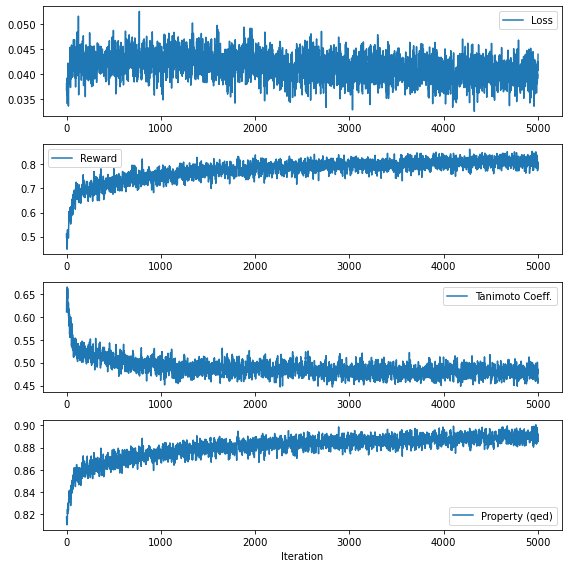

In [14]:
fig, axes = plt.subplots(4,1,figsize=(8,8))

axes[0].plot(df_history.loc[:,"LOSS"], label="Loss")
axes[1].plot(df_history.loc[:,"REWARD"], label="Reward")
axes[2].plot(df_history.loc[:,"SIMILARITY"], label="Tanimoto Coeff.")
axes[3].plot(df_history.loc[:,"PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[3].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

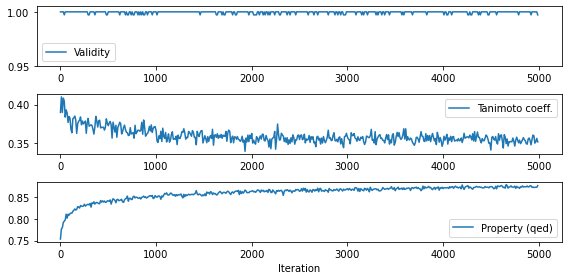

In [15]:
fig, axes = plt.subplots(3,1,figsize=(8,4))

axes[0].plot(df_history_valid.loc[:,"VALID_RATIO"], label="Validity")
axes[1].plot(df_history_valid.loc[:,"AVERAGE_SIMILARITY"], label="Tanimoto coeff.")
axes[2].plot(df_history_valid.loc[:,"AVERAGE_PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[0].set_ylim(0.95, 1.005)

axes[2].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()